In [1]:
%matplotlib inline

from __future__ import unicode_literals
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import matplotlib.patches as patches

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython import display
from IPython.display import HTML, Image, clear_output

In [2]:
class GridWorldEnv(gym.Env):
    
    #The action space constitutes of the following moves:
    #    0: Right
    #    1: Up
    #    2: Left
    #    3: Down
    
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 100
    }
    
    def __init__(self, grid_size = 5, rewarded_locations = [[0,1],[0,3]], 
                 rewarded_targets=[[4,1],[2,3]], reward_vals = [10, 5], 
                 hard_version=False):
        
        #Defining the grid size
        if isinstance(grid_size, int):
            self.width=self.height=grid_size
        else:
            self.width = grid_size[0]
            self.height = grid_size[1]
            
        
        #Defining A,B,A',B'
        self.rewarded_locations = np.array(rewarded_locations, dtype=np.int)
        self.rewarded_targets = np.array(rewarded_targets, dtype=np.int)
        self.reward_vals = np.array(reward_vals)
        
        #Defining the action space and observation space
        self.action_space = spaces.Discrete(4)
        self.move_dict = {0: np.array([ 1, 0]),
                          1: np.array([ 0, 1]),
                          2: np.array([-1, 0]),
                          3: np.array([ 0,-1])}
        self.observation_space = spaces.MultiDiscrete([self.width, self.height])
        
        self.hard_version=hard_version
        
        #Setting the seed
        self.seed()
        
        self.viewer = None
        self.state = None
        self.exp_history=[]
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def reset(self):
        self.state = self.observation_space.sample()
        self.steps_beyond_done = None
        self.exp_history.append({'states':[], 'actions':[], 'rewards':[]})
        return np.array(self.state)
    
    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        
        reward = None
        
        if self.hard_version:
            if np.random.random_sample() < 0.1:
                action = np.random.choice(4)
        
        for i,loc in enumerate(self.rewarded_locations):
            if (self.state[0] == loc[0] and self.state[1] == loc[1]): 
                reward = self.reward_vals[i]
                self.state = self.rewarded_targets[i,:]
                
        if reward is None:
            movement = self.move_dict[action]
            next_state = self.state + movement
            if self.observation_space.contains(next_state):
                reward = 0
                self.state = next_state
            else:
                reward = -1
        
        done=False
        
        self.exp_history[-1]['states'].append(self.state)
        self.exp_history[-1]['actions'].append(action)
        self.exp_history[-1]['rewards'].append(reward)
        
        return np.array(self.state), reward, done, {}
    
    def render(self, mode='human'):
        screen_width = 600
        screen_height = 600
        
        top_left = [50,50]
        cell_size = 100
        point_size = 30
        
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            
            for i in range(self.width):
                for j in range(self.height):
                    l = i*cell_size + top_left[0]
                    r = (i+1)*cell_size + top_left[0]
                    t = j*cell_size + top_left[1]
                    b = (j+1)*cell_size + top_left[1]
                    
                    cart = rendering.PolyLine([(l,b), (l,t), (r,t), (r,b)], True)
                    cart.set_color(0,0,0)
                    carttrans = rendering.Transform()
                    cart.add_attr(carttrans)
                    self.viewer.add_geom(cart)
            
            i = 0
            j = 0

            l = top_left[0] + cell_size/2 - point_size/2
            r = top_left[0] + cell_size/2 + point_size/2
            t = top_left[1] + cell_size/2 - point_size/2
            b = top_left[1] + cell_size/2 + point_size/2
            self.point = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            self.point.set_color(1,0,0)
            #FilledPolygon
            
            self.pointtrans = rendering.Transform(translation=(0, 0))
            self.point.add_attr(self.pointtrans)
            self.viewer.add_geom(self.point)
            
        #Drawing the point
        if self.state is None: return None
        
        i = self.state[0]
        j = self.state[1]

        x = i*cell_size 
        y = j*cell_size
        self.pointtrans.set_translation(x, y)
        
        return self.viewer.render(return_rgb_array = mode=='rgb_array')
    
    def plt_render(self):
        
        point_radius = 0.1
        
        all_states = self.exp_history[-1]['states']
        all_actions = self.exp_history[-1]['actions']
        all_rewards = self.exp_history[-1]['rewards']
        
        row = [s[0] for _,s in enumerate(all_states)]
        col = [s[1] for _,s in enumerate(all_states)]
        time_array = np.arange(len(row))
        
        self.figure = plt.figure()
        self.figure.set_size_inches(15, 15, forward=True)
        
        self.act_ax = plt.subplot2grid((4, 4), (0, 0))
        self.row_ax = plt.subplot2grid((4, 4), (0, 1))
        self.reward_ax = plt.subplot2grid((4, 4), (1, 0))
        self.col_ax = plt.subplot2grid((4, 4), (1, 1))
        self.traj_ax = plt.subplot2grid((4, 4), (2, 0), colspan=2, rowspan=2)
        
        self.traj_ax.set_xlim([-0.5, self.width - 0.5])
        self.traj_ax.set_ylim([-0.5, self.height - 0.5])
        
        plot_ax_list = [self.act_ax, self.row_ax,
                        self.reward_ax, self.col_ax]
        plot_data_list = [all_actions, row, all_rewards, col]
        plot_title_list = [r'$a$', r'$row$',
                           r'$R$', r'$column$']
        
        
        for i,curr_ax in enumerate(plot_ax_list):
            curr_data=plot_data_list[i]
            curr_ax.set_xlim([0,time_array[-1]])
            if np.min(curr_data) == np.max(curr_data):
                curr_ax.set_ylim([np.min(curr_data) - 1, np.max(curr_data) + 1])
            else:
                curr_ax.set_ylim([1.05*np.min(curr_data),1.05*np.max(curr_data)])
            curr_ax.set_title(plot_title_list[i], fontsize=16)
        
        for k in range(self.height-1):
            self.traj_ax.axhline(y = k+0.5)
        for k in range(self.width-1):
            self.traj_ax.axvline(x = k+0.5)
        self.point = patches.Circle((0,0),point_radius,linewidth=10,edgecolor='r',facecolor='r')
        self.traj_ax.add_patch(self.point)
        
        #point.set_center((0,0))
        self.traj_ax.set_title('Trajectory', fontsize=16)
        
        self.plot_lines = []
        for i,curr_ax in enumerate(plot_ax_list):
            curr_line, = curr_ax.plot([], [], color='k')
            self.plot_lines.append(curr_line)

        def init():
            self.point.center = (0,0)
            for curr_line in self.plot_lines:
                curr_line.set_data([], [])
            return self.point, self.plot_lines[0], self.plot_lines[1], self.plot_lines[2], \
                    self.plot_lines[3]

        def animate(i):

            self.point.center=(col[i], self.height - row[i])
            
            for j,curr_line in enumerate(self.plot_lines):
                curr_data = plot_data_list[j]
                curr_line.set_data(time_array[:i], curr_data[:i])
            return self.point, self.plot_lines[0], self.plot_lines[1], self.plot_lines[2], \
                    self.plot_lines[3]

        self.ani = animation.FuncAnimation(self.figure, animate, np.arange(len(row)),
                                           interval=25, blit=True, init_func=init)
    
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [3]:
%matplotlib inline
env = GridWorldEnv()
try:
    for i_episode in range(1):
        observation = env.reset()
        for t in range(100):
            #env.render(mode = 'human')
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            #print(observation, reward)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
    env.close()
except (KeyboardInterrupt, SystemExit):
    env.close()

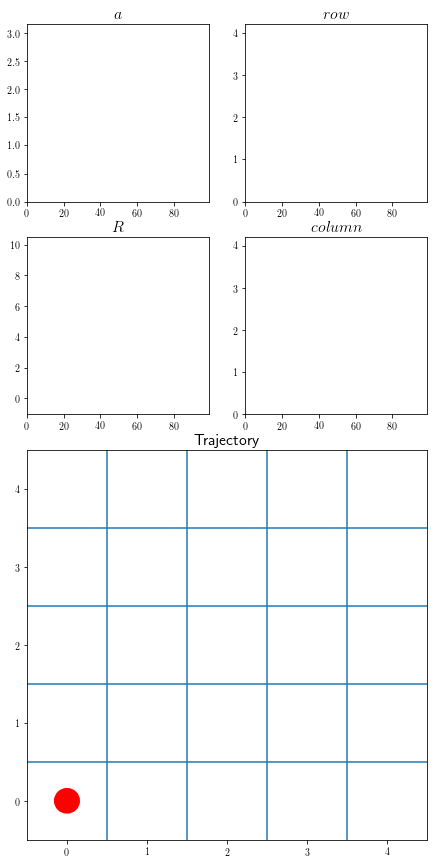

In [4]:
%matplotlib inline
env.plt_render()
#clear_output(wait=True)

In [5]:
HTML(env.ani.to_jshtml(fps = 10))

In [ ]:
env.ani.save('./problem1.gif', writer=animation.PillowWriter(fps=10))